# Classification of local minimums and maximums

The objective of this notebook is to perform classification on the data factored in `feature_creation.ipynb`. As local minimum or maximum are known a posteriori we want to employ CNN to infer a prediction.

The date range is from `2020-04-01` to `2023-12-31` as it contains trends both upwards and downwards for the stock `DAL` quoted on the Milan Stock Exchange.

The column `feature` of our dataframe can assume values:
- `max` if the price is a local maximum
- `min` if the price is a local minimum
- `def` otherwise


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, Dense, Flatten, Dropout, LeakyReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2

from sklearn.preprocessing import MinMaxScaler
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

2023-12-01 18:30:20.142814: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-01 18:30:20.174339: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-01 18:30:20.174373: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-01 18:30:20.174392: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-01 18:30:20.179819: I tensorflow/core/platform/cpu_feature_g

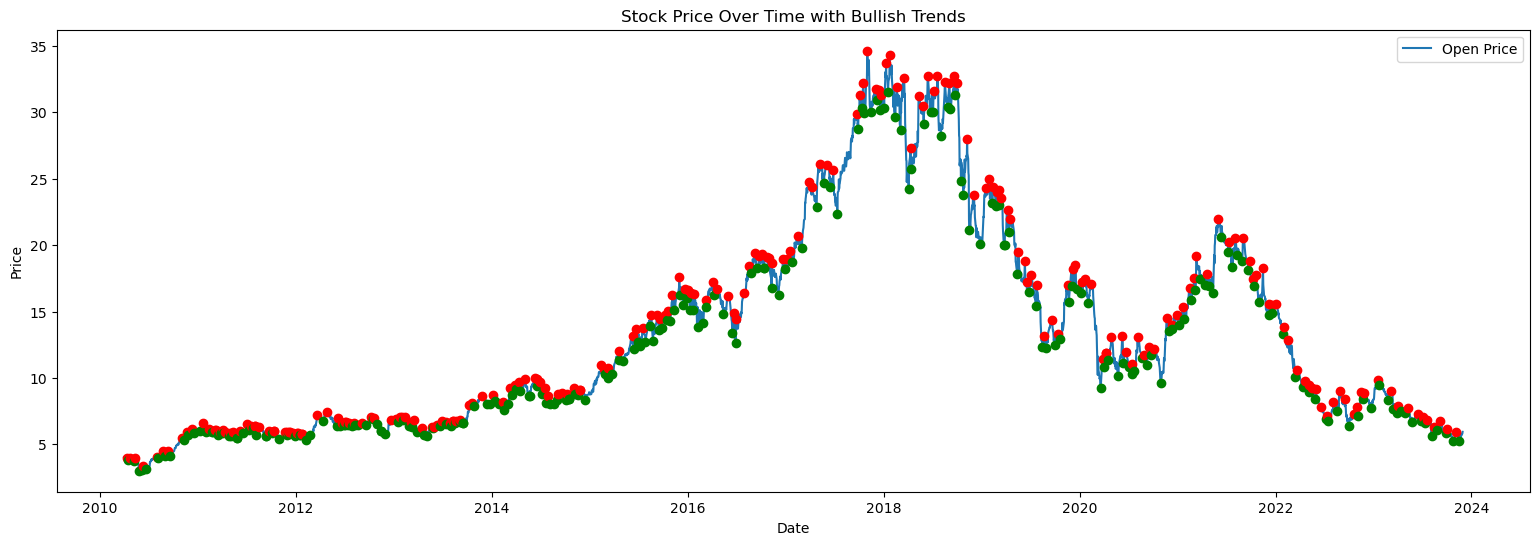

In [2]:
start = "2013-04-01"
end = "2023-04-01"
df = pd.read_csv('data/DAL.MI_f.csv', index_col=0, parse_dates=True)

plt.figure(figsize=(19, 6))
plt.plot(df['Open'], label='Open Price')
for index in range(0, df.shape[0]):
    el = df['feature'].iloc[index]
    if (el == 'max'):
        plt.plot(df.index[index], df['Open'].iloc[index], 'ro')
    if (el == 'min'):
        plt.plot(df.index[index], df['Open'].iloc[index], 'go')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Stock Price Over Time with Bullish Trends')
plt.legend()
plt.show()

As the single price would not mean much without context the objective will be to
gather together a sequence of trading days to predict if the current day is a minimum a maximum or nothing.

In [43]:
n_features = 3

data = np.array(df.drop('feature', axis=1).values)

feature_mapping = {'min': 0, 'def': 1, 'max': 2}
inverted_mapping = {value: key for key, value in feature_mapping.items()}
target = np.array(df['feature'].map(feature_mapping).values)

scaler_data = MinMaxScaler()
scaler_data.fit(data)
data = scaler_data.transform(data)

train_size = int(len(data) * 0.80)

n_timesteps = 16
def create_sequences(data, target, n_timesteps):
    X, y = [], []
    for i in range(len(data) - n_timesteps):
        X.append(data[i:i+n_timesteps])
        y.append(target[i+15])
    return np.array(X), np.array(y)

data_seq, target_seq = create_sequences(data, target, n_timesteps)

x_train, x_test = np.array(data_seq[:train_size]), np.array(data_seq[train_size:])
y_train_class, y_test_class = np.array(target_seq[:train_size]), np.array(target_seq[train_size:])

y_train = np.eye(n_features)[y_train_class]
y_test = np.eye(n_features)[y_test_class]

In [44]:
index = 0
col = 0
print(f'{x_train[index][0][col]} | {inverted_mapping[y_train_class[index]]}')

y_train[index]

0.032247873497315616 | def


array([0., 1., 0.])

In [45]:
def build_model(input_shape, l2_value):
    kernel_size = 3
    pool_size = 1
    l2_ = l2(l2_value)
    alpha = 0.4
    model = Sequential()
    model.add(Input(shape=input_shape))
    model.add(Conv1D(32, data_format="channels_last", kernel_size=kernel_size, activation=LeakyReLU(alpha=alpha)))
    model.add(MaxPooling1D(pool_size=pool_size))
    model.add(Conv1D(54, kernel_size=kernel_size, kernel_regularizer=l2_, bias_regularizer=l2_))
    model.add(MaxPooling1D(pool_size=pool_size))
    model.add(Conv1D(128, kernel_size=kernel_size, activation=LeakyReLU(alpha=alpha), kernel_regularizer=l2_, bias_regularizer=l2_))
    model.add(MaxPooling1D(pool_size=pool_size))
    model.add(Conv1D(256, kernel_size=kernel_size, kernel_regularizer=l2_, bias_regularizer=l2_))
    model.add(MaxPooling1D(pool_size=pool_size))

    model.add(Flatten())

    model.add(Dense(256, activation='relu', kernel_regularizer=l2_, bias_regularizer=l2_))
    model.add(Dense(256, activation='relu', kernel_regularizer=l2_, bias_regularizer=l2_))

    model.add(Dense(n_features, activation='softmax'))

    return model



In [46]:
# As we have unbalanced classes:
class_weights = compute_class_weight('balanced', classes=np.unique(target_seq), y=target_seq)
class_weights = class_weights / class_weights[1]
class_weight_dict = dict(enumerate(class_weights))
print(f'dicts: {class_weight_dict}')

dicts: {0: 12.931034482758621, 1: 1.0, 2: 13.157894736842106}


In [47]:
batch_size = 512
epochs = 1000
patience = 100
l2_value = 0.002

input_shape = (n_timesteps, 6)

model = build_model(input_shape, l2_value)

model.compile(loss='categorical_crossentropy',
            optimizer=Adam(),
            metrics=['accuracy', Precision(), Recall()])

history = model.fit(x_train, y_train,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_split=0.2,
                    class_weight = class_weight_dict,
                    callbacks=[EarlyStopping(
                        monitor='val_loss',
                        patience=patience,
                        verbose=2,
                        mode='min',
                        restore_best_weights=True,
                    )])

Epoch 1/1000
5/5 [==============================] - 1s 69ms/step - loss: 4.8628 - accuracy: 0.4577 - precision_9: 0.0000e+00 - recall_9: 0.0000e+00 - val_loss: 2.9315 - val_accuracy: 0.0701 - val_precision_9: 0.0000e+00 - val_recall_9: 0.0000e+00
Epoch 2/1000
5/5 [==============================] - 0s 30ms/step - loss: 4.5982 - accuracy: 0.2410 - precision_9: 0.0000e+00 - recall_9: 0.0000e+00 - val_loss: 2.6075 - val_accuracy: 0.8633 - val_precision_9: 0.0000e+00 - val_recall_9: 0.0000e+00
Epoch 3/1000
5/5 [==============================] - 0s 27ms/step - loss: 4.3857 - accuracy: 0.1664 - precision_9: 0.0000e+00 - recall_9: 0.0000e+00 - val_loss: 2.4562 - val_accuracy: 0.0683 - val_precision_9: 0.0000e+00 - val_recall_9: 0.0000e+00
Epoch 4/1000
5/5 [==============================] - 0s 26ms/step - loss: 4.2025 - accuracy: 0.2140 - precision_9: 0.0000e+00 - recall_9: 0.0000e+00 - val_loss: 2.2777 - val_accuracy: 0.0665 - val_precision_9: 0.0000e+00 - val_recall_9: 0.0000e+00
Epoch 5/1000

In [49]:
y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = y_test_class

conf_matrix = confusion_matrix(y_true, y_pred_classes)

accuracy = accuracy_score(y_true, y_pred_classes)
report = classification_report(y_true, y_pred_classes)

print("Accuracy:", accuracy)
print("\nConfusion Matrix:\n", conf_matrix)
print("\nClassification Report:\n", report)


22/22 [==============================] - 0s 2ms/step
Accuracy: 0.638235294117647

Confusion Matrix:
 [[ 33   6   0]
 [157 366  79]
 [  1   3  35]]

Classification Report:
               precision    recall  f1-score   support

           0       0.17      0.85      0.29        39
           1       0.98      0.61      0.75       602
           2       0.31      0.90      0.46        39

    accuracy                           0.64       680
   macro avg       0.49      0.78      0.50       680
weighted avg       0.89      0.64      0.71       680



22/22 [==============================] - 0s 2ms/step<br>
Accuracy: 0.8323529411764706

Confusion Matrix:<br>
 [[ 31   8   0]<br>
 [ 61 507  34] <br>
 [  0  11  28]]<br>

Classification Report:
               precision    recall  f1-score   support

           0       0.34      0.79      0.47        39
           1       0.96      0.84      0.90       602
           2       0.45      0.72      0.55        39

    accuracy                           0.83       680
   macro avg       0.58      0.79      0.64       680
weighted avg       0.90      0.83      0.85       680